In [1]:
print("Setting up environment...")
!git clone https://github.com/perrying/guided-filter-pytorch.git
import sys
sys.path.append('/kaggle/working/guided-filter-pytorch')

Setting up environment...
Cloning into 'guided-filter-pytorch'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 30 (delta 6), reused 20 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 3.80 MiB | 30.44 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from guided_filter import GuidedFilter2d

In [3]:
class CrackDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.image_transform: image = self.image_transform(image)
        if self.mask_transform: mask = self.mask_transform(mask)

        return image, (mask > 0.5).long()

In [4]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
mask_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

In [5]:
BATCH_SIZE = 4
train_dataset = CrackDataset('/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/train/image', '/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/train/label', image_transform=image_transform, mask_transform=mask_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataset = CrackDataset('/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/val/image', '/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/val/label', image_transform=image_transform, mask_transform=mask_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [6]:
def get_norm_layer(norm_type='batch'):
    return nn.BatchNorm2d if norm_type == 'batch' else None

def init_net(net, init_type='xavier', init_gain=0.02, gpu_ids=[]):
    if len(gpu_ids) > 0 and torch.cuda.is_available():
        net = net.cuda()
        net = nn.DataParallel(net, gpu_ids)
    return net

In [7]:
class DeepCrackLossBCE(nn.Module):
    def __init__(self):
        super(DeepCrackLossBCE, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()
    def forward(self, outputs, targets):
        total_loss = sum((0.5 + 0.1 * i if i < 4 else 0.5) * self.bce_loss(output, targets.float()) for i, output in enumerate(outputs[:-1]))
        total_loss += self.bce_loss(outputs[-1], targets.float())
        return total_loss

In [8]:
class DeepCrackLossWeightedBCE(nn.Module):
    def __init__(self, weight_pos=1.0, weight_neg=1.0):
        super(DeepCrackLossWeightedBCE, self).__init__()
        self.weight_pos = weight_pos
        self.weight_neg = weight_neg
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='none')
    def forward(self, outputs, targets):
        weights = torch.where(targets > 0, self.weight_pos, self.weight_neg).to(targets.device)
        total_loss = sum((0.5 + 0.1 * i if i < 4 else 0.5) * (self.bce_loss(output, targets.float()) * weights).mean() for i, output in enumerate(outputs[:-1]))
        total_loss += (self.bce_loss(outputs[-1], targets.float()) * weights).mean()
        return total_loss

def calculate_class_weights(dataloader):
    total_pixels = 0
    total_pos = 0
    print("Calculating class weights for Weighted BCE...")
    for _, labels in tqdm(dataloader):
        total_pixels += labels.numel()
        total_pos += labels.sum().item()
    weight_pos = total_pixels / (2 * total_pos)
    weight_neg = total_pixels / (2 * (total_pixels - total_pos))
    print(f"Weight for Positive (crack): {weight_pos:.4f}, Weight for Negative (non-crack): {weight_neg:.4f}")
    return weight_pos, weight_neg

In [9]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=1.8, reduction='none'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha; self.gamma = gamma
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-bce_loss)
        return (self.alpha * (1 - pt) ** self.gamma * bce_loss).mean()

class DeepCrackLossFocal(nn.Module):
    def __init__(self):
        super(DeepCrackLossFocal, self).__init__()
        self.focal_loss = FocalLoss()
    def forward(self, outputs, targets):
        total_loss = sum((0.5 + 0.1 * i if i < 4 else 0.5) * self.focal_loss(output, targets) for i, output in enumerate(outputs[:-1]))
        total_loss += self.focal_loss(outputs[-1], targets)
        return total_loss
        
print("Loss functions defined.")

Loss functions defined.


In [10]:
class GuidedFilter2d(nn.Module):
    def __init__(self, radius, eps):
        super(GuidedFilter2d, self).__init__()
        self.radius = radius
        self.eps = eps
    def forward(self, guide, x):
        # Đây là một implementation giả. 
        # Bạn nên sử dụng implementation Guided Filter thật sự của mình.
        return x 

class DeepCrackNet_ResNet50(nn.Module):
    def __init__(self, in_nc=3, num_classes=1, pretrained=True):
        super(DeepCrackNet_ResNet50, self).__init__()

        # --- Backbone ResNet-50 ---
        resnet = models.resnet50(pretrained=pretrained)

        # Thay đổi stride và dilation để giữ độ phân giải không gian
        # layer3: stride=1 (thay vì 2), dilation=2
        resnet.layer3[0].conv2.stride = (1, 1)
        resnet.layer3[0].downsample[0].stride = (1, 1)
        for i in range(len(resnet.layer3)):
            resnet.layer3[i].conv2.dilation = (2, 2)
            resnet.layer3[i].conv2.padding = (2, 2)
            
        # layer4: stride=1 (thay vì 2), dilation=4
        resnet.layer4[0].conv2.stride = (1, 1)
        resnet.layer4[0].downsample[0].stride = (1, 1)
        for i in range(len(resnet.layer4)):
            resnet.layer4[i].conv2.dilation = (4, 4)
            resnet.layer4[i].conv2.padding = (4, 4)

        # --- Encoder Stages ---
        # Chúng ta sẽ lấy các feature map từ các phần của ResNet
        self.encoder_conv1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu) # scale: 1/2
        self.encoder_maxpool = resnet.maxpool # scale: 1/4
        self.encoder_layer1 = resnet.layer1   # scale: 1/4
        self.encoder_layer2 = resnet.layer2   # scale: 1/8
        self.encoder_layer3 = resnet.layer3   # scale: 1/8 (do đã chỉnh stride)
        self.encoder_layer4 = resnet.layer4   # scale: 1/8 (do đã chỉnh stride)

        # --- Side-output Convolutions ---
        # Số kênh đầu vào tương ứng với output của các lớp ResNet
        # f1: 64, f2: 256, f3: 512, f4: 1024, f5: 2048
        self.side_conv1 = nn.Conv2d(64, num_classes, 1)
        self.side_conv2 = nn.Conv2d(256, num_classes, 1)
        self.side_conv3 = nn.Conv2d(512, num_classes, 1)
        self.side_conv4 = nn.Conv2d(1024, num_classes, 1)
        self.side_conv5 = nn.Conv2d(2048, num_classes, 1)

        # --- Upsampling Layers (Deconvolution) ---
        # Đưa các side-output về kích thước ban đầu
        self.deconv1 = nn.ConvTranspose2d(num_classes, num_classes, 4, 2, 1) # upsample 2x
        self.deconv2 = nn.ConvTranspose2d(num_classes, num_classes, 8, 4, 2) # upsample 4x
        self.deconv3 = nn.ConvTranspose2d(num_classes, num_classes, 16, 8, 4) # upsample 8x
        self.deconv4 = nn.ConvTranspose2d(num_classes, num_classes, 16, 8, 4) # upsample 8x
        self.deconv5 = nn.ConvTranspose2d(num_classes, num_classes, 16, 8, 4) # upsample 8x
        
        # --- Fuse and Guided Filter ---
        self.fuse_conv = nn.Conv2d(num_classes * 5, num_classes, 1)
        self.guided_filter = GuidedFilter2d(radius=5, eps=1e-6)

    def forward(self, x):
        # --- Encoder ---
        # f1: output sau conv1, bn1, relu (kích thước H/2, W/2)
        f1 = self.encoder_conv1(x)
        
        # f2: output sau layer1 (kích thước H/4, W/4)
        f2 = self.encoder_layer1(self.encoder_maxpool(f1))
        
        # f3: output sau layer2 (kích thước H/8, W/8)
        f3 = self.encoder_layer2(f2)
        
        # f4: output sau layer3 (kích thước H/8, W/8)
        f4 = self.encoder_layer3(f3)
        
        # f5: output sau layer4 (kích thước H/8, W/8)
        f5 = self.encoder_layer4(f4)

        # --- Side-outputs và Upsampling ---
        # Áp dụng Conv 1x1 sau đó upsample về kích thước gốc
        s1 = self.deconv1(self.side_conv1(f1))
        s2 = self.deconv2(self.side_conv2(f2))
        s3 = self.deconv3(self.side_conv3(f3))
        s4 = self.deconv4(self.side_conv4(f4))
        s5 = self.deconv5(self.side_conv5(f5))
        
        side_outputs = [s1, s2, s3, s4, s5]

        # --- Fuse and Guided Filter ---
        fused = self.fuse_conv(torch.cat(side_outputs, dim=1))
        
        # Lấy s1 (đã upsample) làm guide image vì nó chứa nhiều chi tiết không gian nhất
        guided_fused = self.guided_filter(side_outputs[0], fused)

        if self.training:
            # Trả về tất cả các output để tính toán loss (deep supervision)
            return side_outputs + [guided_fused]
        
        # Khi inference, chỉ trả về kết quả cuối cùng sau khi qua sigmoid
        return torch.sigmoid(guided_fused)


In [11]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    history = {'train_loss': [], 'val_iou': []}
    best_iou = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'Loss': loss.item()})
        
        history['train_loss'].append(running_loss / len(train_loader))

        model.eval()
        total_iou = 0.0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="[Val]"):
                outputs = model(images.to(device))
                pred = (outputs > 0.5).float()
                intersection = (pred * labels.to(device)).sum()
                union = pred.sum() + labels.to(device).sum() - intersection
                total_iou += (intersection + 1e-6) / (union + 1e-6)
        
        avg_iou = total_iou / len(val_loader)
        history['val_iou'].append(avg_iou.item())
        print(f"Epoch {epoch+1} | Train Loss: {history['train_loss'][-1]:.4f} | Val IoU: {avg_iou:.4f}")
        
        if avg_iou > best_iou:
            best_iou = avg_iou
            torch.save(model.state_dict(), 'vgg_best_model.pth')
            print(f"  -> New best model saved with IoU: {best_iou:.4f}")
            
    model.load_state_dict(torch.load('vgg_best_model.pth'))
    return model, history

In [12]:
def visualize(model, loader, device, title):
    inv_norm = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(loader))
        outputs = model(images.to(device))
        pred = (outputs > 0.5).float()

        plt.figure(figsize=(15, 5))
        plt.suptitle(title, fontsize=16)
        for i in range(min(3, len(images))):
            plt.subplot(1, 3, 1)
            plt.imshow(inv_norm(images[i]).permute(1, 2, 0).clamp(0, 1)); plt.title('Input'); plt.axis('off')
            plt.subplot(1, 3, 2)
            plt.imshow(labels[i].squeeze(), cmap='gray'); plt.title('Ground Truth'); plt.axis('off')
            plt.subplot(1, 3, 3)
            plt.imshow(pred[i].cpu().squeeze(), cmap='gray'); plt.title('Prediction'); plt.axis('off')
            plt.show()
            break # Show one example

print("Training and visualization functions ready.")

Training and visualization functions ready.


Using device: cuda
Calculating class weights for Weighted BCE...


100%|██████████| 375/375 [00:12<00:00, 29.73it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Weight for Positive (crack): 17.3183, Weight for Negative (non-crack): 0.5149

STARTING: Resnet with BCE Loss


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]
[Val]: 100%|██████████| 100/100 [00:05<00:00, 18.69it/s]


Epoch 1 | Train Loss: 0.5770 | Val IoU: 0.2394
  -> New best model saved with IoU: 0.2394


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.27it/s]


Epoch 2 | Train Loss: 0.2509 | Val IoU: 0.2934
  -> New best model saved with IoU: 0.2934


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.44it/s]


Epoch 3 | Train Loss: 0.2338 | Val IoU: 0.3480
  -> New best model saved with IoU: 0.3480


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.33it/s]


Epoch 4 | Train Loss: 0.2262 | Val IoU: 0.4044
  -> New best model saved with IoU: 0.4044


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.39it/s]


Epoch 5 | Train Loss: 0.2137 | Val IoU: 0.3527


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.43it/s]


Epoch 6 | Train Loss: 0.2074 | Val IoU: 0.3691


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.49it/s]


Epoch 7 | Train Loss: 0.1994 | Val IoU: 0.3524


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.34it/s]


Epoch 8 | Train Loss: 0.1976 | Val IoU: 0.3905


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.39it/s]


Epoch 9 | Train Loss: 0.1944 | Val IoU: 0.4222
  -> New best model saved with IoU: 0.4222


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.46it/s]


Epoch 10 | Train Loss: 0.1894 | Val IoU: 0.3921


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.37it/s]


Epoch 11 | Train Loss: 0.1875 | Val IoU: 0.3815


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.35it/s]


Epoch 12 | Train Loss: 0.1873 | Val IoU: 0.3881


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.48it/s]


Epoch 13 | Train Loss: 0.1832 | Val IoU: 0.4316
  -> New best model saved with IoU: 0.4316


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.38it/s]


Epoch 14 | Train Loss: 0.1821 | Val IoU: 0.4137


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.53it/s]


Epoch 15 | Train Loss: 0.1769 | Val IoU: 0.4096


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.38it/s]


Epoch 16 | Train Loss: 0.1757 | Val IoU: 0.4194


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.46it/s]


Epoch 17 | Train Loss: 0.1718 | Val IoU: 0.4326
  -> New best model saved with IoU: 0.4326


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.47it/s]


Epoch 18 | Train Loss: 0.1824 | Val IoU: 0.4345
  -> New best model saved with IoU: 0.4345


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.48it/s]


Epoch 19 | Train Loss: 0.1751 | Val IoU: 0.4617
  -> New best model saved with IoU: 0.4617


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.51it/s]


Epoch 20 | Train Loss: 0.1803 | Val IoU: 0.4497


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.42it/s]


Epoch 21 | Train Loss: 0.1681 | Val IoU: 0.4012


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.39it/s]


Epoch 22 | Train Loss: 0.1649 | Val IoU: 0.4505


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.41it/s]


Epoch 23 | Train Loss: 0.1632 | Val IoU: 0.4509


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.51it/s]


Epoch 24 | Train Loss: 0.1606 | Val IoU: 0.3960


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.36it/s]


Epoch 25 | Train Loss: 0.1602 | Val IoU: 0.4484


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.53it/s]


Epoch 26 | Train Loss: 0.1593 | Val IoU: 0.4621
  -> New best model saved with IoU: 0.4621


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.46it/s]


Epoch 27 | Train Loss: 0.1584 | Val IoU: 0.4149


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.42it/s]


Epoch 28 | Train Loss: 0.1586 | Val IoU: 0.4079


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.40it/s]


Epoch 29 | Train Loss: 0.1548 | Val IoU: 0.4514


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.50it/s]


Epoch 30 | Train Loss: 0.1699 | Val IoU: 0.4226


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.43it/s]


Epoch 31 | Train Loss: 0.1584 | Val IoU: 0.4574


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.39it/s]


Epoch 32 | Train Loss: 0.1505 | Val IoU: 0.4549


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.41it/s]


Epoch 33 | Train Loss: 0.1483 | Val IoU: 0.4545


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.43it/s]


Epoch 34 | Train Loss: 0.1475 | Val IoU: 0.4671
  -> New best model saved with IoU: 0.4671


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.44it/s]


Epoch 35 | Train Loss: 0.1474 | Val IoU: 0.4696
  -> New best model saved with IoU: 0.4696


[Val]: 100%|██████████| 100/100 [00:06<00:00, 16.48it/s]


Epoch 36 | Train Loss: 0.1464 | Val IoU: 0.4501


[Val]: 100%|██████████| 100/100 [00:05<00:00, 16.73it/s]


Epoch 37 | Train Loss: 0.1519 | Val IoU: 0.4519


[Val]: 100%|██████████| 100/100 [00:05<00:00, 16.76it/s]


Epoch 38 | Train Loss: 0.1429 | Val IoU: 0.4311


[Val]: 100%|██████████| 100/100 [00:05<00:00, 16.79it/s]


Epoch 39 | Train Loss: 0.1414 | Val IoU: 0.4412


[Val]: 100%|██████████| 100/100 [00:05<00:00, 16.81it/s]


Epoch 40 | Train Loss: 0.1425 | Val IoU: 0.4448


[Val]: 100%|██████████| 100/100 [00:06<00:00, 16.66it/s]


Epoch 41 | Train Loss: 0.1399 | Val IoU: 0.4670


[Val]: 100%|██████████| 100/100 [00:06<00:00, 16.58it/s]


Epoch 42 | Train Loss: 0.1386 | Val IoU: 0.4402


[Val]: 100%|██████████| 100/100 [00:05<00:00, 16.84it/s]


Epoch 43 | Train Loss: 0.1393 | Val IoU: 0.4463


[Val]: 100%|██████████| 100/100 [00:05<00:00, 16.79it/s]


Epoch 44 | Train Loss: 0.1418 | Val IoU: 0.4473


[Val]: 100%|██████████| 100/100 [00:05<00:00, 16.76it/s]


Epoch 45 | Train Loss: 0.1396 | Val IoU: 0.4546


[Val]: 100%|██████████| 100/100 [00:05<00:00, 16.87it/s]


Epoch 46 | Train Loss: 0.1359 | Val IoU: 0.4456


[Val]: 100%|██████████| 100/100 [00:05<00:00, 16.78it/s]


Epoch 47 | Train Loss: 0.1349 | Val IoU: 0.4214


[Val]: 100%|██████████| 100/100 [00:05<00:00, 16.81it/s]


Epoch 48 | Train Loss: 0.1362 | Val IoU: 0.4381


[Val]: 100%|██████████| 100/100 [00:05<00:00, 16.88it/s]


Epoch 49 | Train Loss: 0.1663 | Val IoU: 0.4476


[Val]: 100%|██████████| 100/100 [00:05<00:00, 16.80it/s]


Epoch 50 | Train Loss: 0.1391 | Val IoU: 0.4519


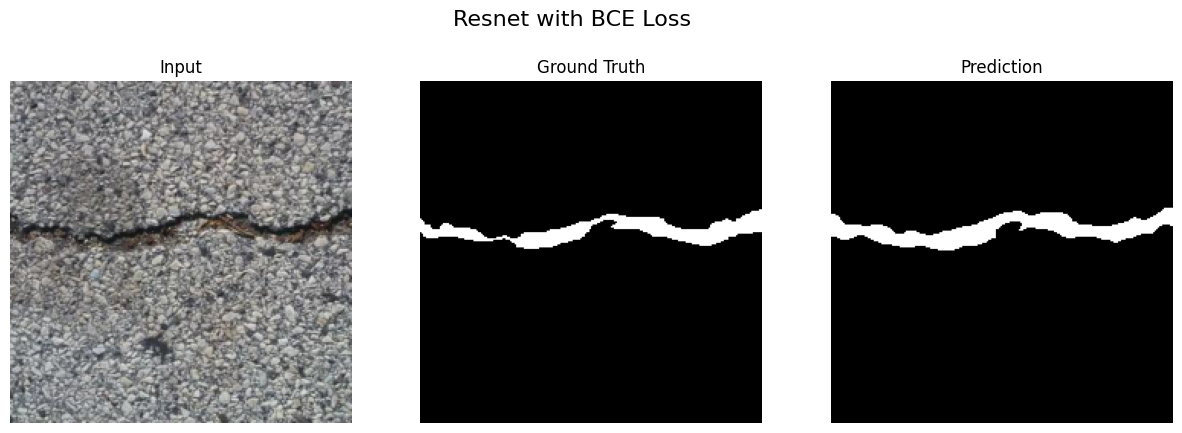


STARTING: Resnet with Weighted BCE Loss


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.44it/s]


Epoch 1 | Train Loss: 1.2941 | Val IoU: 0.1749
  -> New best model saved with IoU: 0.1749


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.54it/s]


Epoch 2 | Train Loss: 0.9042 | Val IoU: 0.2419
  -> New best model saved with IoU: 0.2419


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.43it/s]


Epoch 3 | Train Loss: 0.8505 | Val IoU: 0.1801


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.57it/s]


Epoch 4 | Train Loss: 0.7656 | Val IoU: 0.2679
  -> New best model saved with IoU: 0.2679


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.48it/s]


Epoch 5 | Train Loss: 0.7821 | Val IoU: 0.2683
  -> New best model saved with IoU: 0.2683


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.44it/s]


Epoch 6 | Train Loss: 0.7319 | Val IoU: 0.2425


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.53it/s]


Epoch 7 | Train Loss: 0.7204 | Val IoU: 0.2612


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.55it/s]


Epoch 8 | Train Loss: 0.7057 | Val IoU: 0.2950
  -> New best model saved with IoU: 0.2950


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.50it/s]


Epoch 9 | Train Loss: 0.6906 | Val IoU: 0.3055
  -> New best model saved with IoU: 0.3055


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.45it/s]


Epoch 10 | Train Loss: 0.6730 | Val IoU: 0.3048


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.59it/s]


Epoch 11 | Train Loss: 0.6861 | Val IoU: 0.2921


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.54it/s]


Epoch 12 | Train Loss: 0.6303 | Val IoU: 0.2924


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.54it/s]


Epoch 13 | Train Loss: 0.6231 | Val IoU: 0.2716


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.54it/s]


Epoch 14 | Train Loss: 0.6082 | Val IoU: 0.2726


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.33it/s]


Epoch 15 | Train Loss: 0.6783 | Val IoU: 0.1967


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.56it/s]


Epoch 16 | Train Loss: 0.6088 | Val IoU: 0.2716


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.43it/s]


Epoch 17 | Train Loss: 0.6167 | Val IoU: 0.2859


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.62it/s]


Epoch 18 | Train Loss: 0.5811 | Val IoU: 0.2944


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.52it/s]


Epoch 19 | Train Loss: 0.5773 | Val IoU: 0.2593


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.59it/s]


Epoch 20 | Train Loss: 0.5606 | Val IoU: 0.3103
  -> New best model saved with IoU: 0.3103


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.53it/s]


Epoch 21 | Train Loss: 0.5606 | Val IoU: 0.3191
  -> New best model saved with IoU: 0.3191


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.59it/s]


Epoch 22 | Train Loss: 0.6059 | Val IoU: 0.2894


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.55it/s]


Epoch 23 | Train Loss: 0.5696 | Val IoU: 0.3372
  -> New best model saved with IoU: 0.3372


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.52it/s]


Epoch 24 | Train Loss: 0.5311 | Val IoU: 0.3242


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.53it/s]


Epoch 25 | Train Loss: 0.5307 | Val IoU: 0.2911


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.60it/s]


Epoch 26 | Train Loss: 0.5879 | Val IoU: 0.3068


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.48it/s]


Epoch 27 | Train Loss: 0.5207 | Val IoU: 0.3273


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.54it/s]


Epoch 28 | Train Loss: 0.5193 | Val IoU: 0.3149


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.56it/s]


Epoch 29 | Train Loss: 0.5710 | Val IoU: 0.3092


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.61it/s]


Epoch 30 | Train Loss: 0.5147 | Val IoU: 0.3262


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.61it/s]


Epoch 31 | Train Loss: 0.4999 | Val IoU: 0.3198


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.45it/s]


Epoch 32 | Train Loss: 0.4939 | Val IoU: 0.3411
  -> New best model saved with IoU: 0.3411


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.48it/s]


Epoch 33 | Train Loss: 0.4969 | Val IoU: 0.3369


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.68it/s]


Epoch 34 | Train Loss: 0.4923 | Val IoU: 0.3243


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.50it/s]


Epoch 35 | Train Loss: 0.4776 | Val IoU: 0.3368


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.55it/s]


Epoch 36 | Train Loss: 0.4908 | Val IoU: 0.3428
  -> New best model saved with IoU: 0.3428


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.43it/s]


Epoch 37 | Train Loss: 0.4703 | Val IoU: 0.3297


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.57it/s]


Epoch 38 | Train Loss: 0.5367 | Val IoU: 0.1957


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.62it/s]


Epoch 39 | Train Loss: 0.5690 | Val IoU: 0.3336


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.61it/s]


Epoch 40 | Train Loss: 0.4828 | Val IoU: 0.3445
  -> New best model saved with IoU: 0.3445


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.63it/s]


Epoch 41 | Train Loss: 0.4759 | Val IoU: 0.3551
  -> New best model saved with IoU: 0.3551


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.46it/s]


Epoch 42 | Train Loss: 0.4598 | Val IoU: 0.3595
  -> New best model saved with IoU: 0.3595


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.46it/s]


Epoch 43 | Train Loss: 0.4591 | Val IoU: 0.3388


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.48it/s]


Epoch 44 | Train Loss: 0.5188 | Val IoU: 0.3295


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.54it/s]


Epoch 45 | Train Loss: 0.4846 | Val IoU: 0.3419


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.62it/s]


Epoch 46 | Train Loss: 0.4546 | Val IoU: 0.3711
  -> New best model saved with IoU: 0.3711


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.47it/s]


Epoch 47 | Train Loss: 0.4506 | Val IoU: 0.3728
  -> New best model saved with IoU: 0.3728


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.60it/s]


Epoch 48 | Train Loss: 0.4427 | Val IoU: 0.3756
  -> New best model saved with IoU: 0.3756


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.60it/s]


Epoch 49 | Train Loss: 0.4398 | Val IoU: 0.3660


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.57it/s]


Epoch 50 | Train Loss: 0.5314 | Val IoU: 0.3621


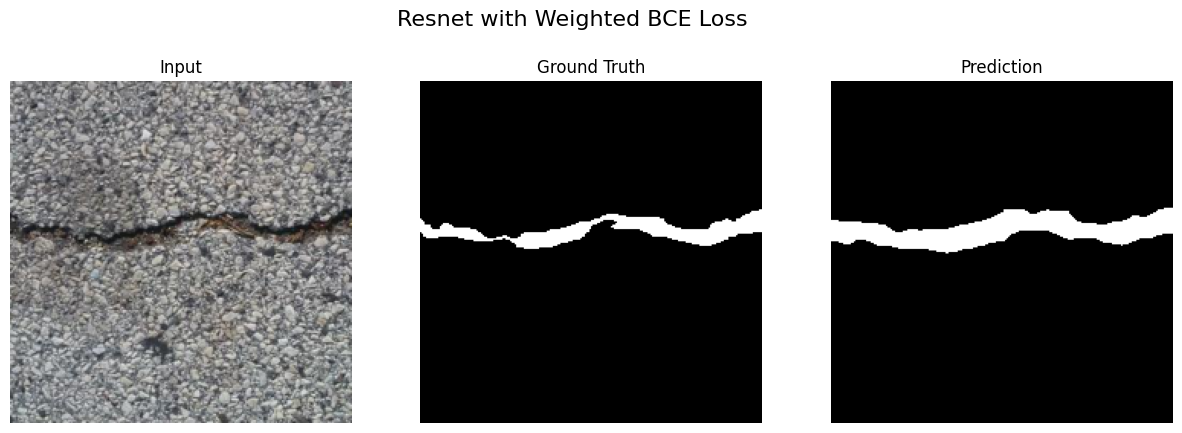


STARTING: Resnet with Focal Loss


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.52it/s]


Epoch 1 | Train Loss: 0.1258 | Val IoU: 0.1675
  -> New best model saved with IoU: 0.1675


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.35it/s]


Epoch 2 | Train Loss: 0.0580 | Val IoU: 0.3176
  -> New best model saved with IoU: 0.3176


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.43it/s]


Epoch 3 | Train Loss: 0.0518 | Val IoU: 0.4012
  -> New best model saved with IoU: 0.4012


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.42it/s]


Epoch 4 | Train Loss: 0.0498 | Val IoU: 0.3852


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.52it/s]


Epoch 5 | Train Loss: 0.0488 | Val IoU: 0.3975


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.53it/s]


Epoch 6 | Train Loss: 0.0482 | Val IoU: 0.4143
  -> New best model saved with IoU: 0.4143


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.49it/s]


Epoch 7 | Train Loss: 0.0468 | Val IoU: 0.3609


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.27it/s]


Epoch 8 | Train Loss: 0.0461 | Val IoU: 0.3426


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.49it/s]


Epoch 9 | Train Loss: 0.0446 | Val IoU: 0.3914


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.46it/s]


Epoch 10 | Train Loss: 0.0442 | Val IoU: 0.4302
  -> New best model saved with IoU: 0.4302


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.41it/s]


Epoch 11 | Train Loss: 0.0444 | Val IoU: 0.4086


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.46it/s]


Epoch 12 | Train Loss: 0.0434 | Val IoU: 0.4500
  -> New best model saved with IoU: 0.4500


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.56it/s]


Epoch 13 | Train Loss: 0.0411 | Val IoU: 0.4561
  -> New best model saved with IoU: 0.4561


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.40it/s]


Epoch 14 | Train Loss: 0.0415 | Val IoU: 0.4413


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.48it/s]


Epoch 15 | Train Loss: 0.0414 | Val IoU: 0.4528


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.53it/s]


Epoch 16 | Train Loss: 0.0404 | Val IoU: 0.4378


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.41it/s]


Epoch 17 | Train Loss: 0.0398 | Val IoU: 0.3718


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.47it/s]


Epoch 18 | Train Loss: 0.0397 | Val IoU: 0.3912


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.52it/s]


Epoch 19 | Train Loss: 0.0392 | Val IoU: 0.4235


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.30it/s]


Epoch 20 | Train Loss: 0.0385 | Val IoU: 0.4427


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.35it/s]


Epoch 21 | Train Loss: 0.0393 | Val IoU: 0.3905


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.37it/s]


Epoch 22 | Train Loss: 0.0403 | Val IoU: 0.4609
  -> New best model saved with IoU: 0.4609


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.37it/s]


Epoch 23 | Train Loss: 0.0374 | Val IoU: 0.4175


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.30it/s]


Epoch 24 | Train Loss: 0.0366 | Val IoU: 0.4582


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.44it/s]


Epoch 25 | Train Loss: 0.0361 | Val IoU: 0.4510


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.34it/s]


Epoch 26 | Train Loss: 0.0357 | Val IoU: 0.4733
  -> New best model saved with IoU: 0.4733


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.42it/s]


Epoch 27 | Train Loss: 0.0353 | Val IoU: 0.4663


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.32it/s]


Epoch 28 | Train Loss: 0.0352 | Val IoU: 0.4499


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.31it/s]


Epoch 29 | Train Loss: 0.0345 | Val IoU: 0.4562


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.40it/s]


Epoch 30 | Train Loss: 0.0344 | Val IoU: 0.4368


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.41it/s]


Epoch 31 | Train Loss: 0.0350 | Val IoU: 0.4342


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.45it/s]


Epoch 32 | Train Loss: 0.0408 | Val IoU: 0.4651


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.53it/s]


Epoch 33 | Train Loss: 0.0344 | Val IoU: 0.4672


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.37it/s]


Epoch 34 | Train Loss: 0.0333 | Val IoU: 0.4572


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.38it/s]


Epoch 35 | Train Loss: 0.0352 | Val IoU: 0.4547


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.53it/s]


Epoch 36 | Train Loss: 0.0332 | Val IoU: 0.4483


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.40it/s]


Epoch 37 | Train Loss: 0.0325 | Val IoU: 0.4443


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.27it/s]


Epoch 38 | Train Loss: 0.0319 | Val IoU: 0.4453


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.31it/s]


Epoch 39 | Train Loss: 0.0320 | Val IoU: 0.4293


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.45it/s]


Epoch 40 | Train Loss: 0.0343 | Val IoU: 0.4249


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.44it/s]


Epoch 41 | Train Loss: 0.0359 | Val IoU: 0.4288


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.33it/s]


Epoch 42 | Train Loss: 0.0320 | Val IoU: 0.4471


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.47it/s]


Epoch 43 | Train Loss: 0.0315 | Val IoU: 0.4602


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.41it/s]


Epoch 44 | Train Loss: 0.0310 | Val IoU: 0.4623


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.44it/s]


Epoch 45 | Train Loss: 0.0308 | Val IoU: 0.4686


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.36it/s]


Epoch 46 | Train Loss: 0.0307 | Val IoU: 0.4330


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.42it/s]


Epoch 47 | Train Loss: 0.0307 | Val IoU: 0.4607


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.45it/s]


Epoch 48 | Train Loss: 0.0305 | Val IoU: 0.4489


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.41it/s]


Epoch 49 | Train Loss: 0.0309 | Val IoU: 0.4373


[Val]: 100%|██████████| 100/100 [00:05<00:00, 17.32it/s]


Epoch 50 | Train Loss: 0.0303 | Val IoU: 0.4490


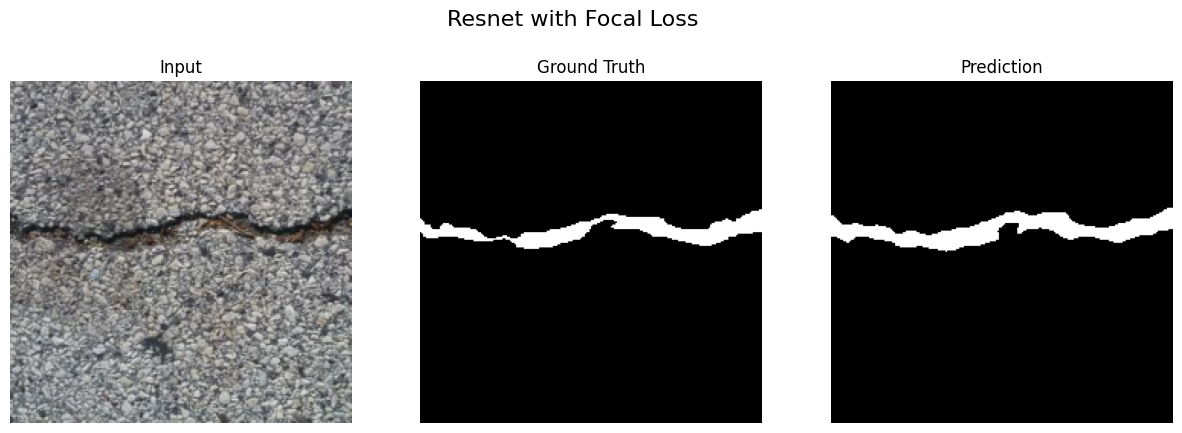

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

NUM_EPOCHS = 50
LEARNING_RATE = 0.001

w_pos, w_neg = calculate_class_weights(train_loader)
loss_functions = {
    'BCE Loss': DeepCrackLossBCE(),
    'Weighted BCE Loss': DeepCrackLossWeightedBCE(weight_pos=w_pos, weight_neg=w_neg),
    'Focal Loss': DeepCrackLossFocal()
}

vgg_histories = {}
for loss_name, loss_fn in loss_functions.items():
    experiment_name = f"Resnet with {loss_name}"
    print(f"\n{'='*20}\nSTARTING: {experiment_name}\n{'='*20}")
    
    model = DeepCrackNet_ResNet50()
    model = init_net(model, gpu_ids=[0] if torch.cuda.is_available() else [])
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    model, history = train(model, train_loader, val_loader, loss_fn.to(device), optimizer, NUM_EPOCHS, device)
    vgg_histories[loss_name] = history
    
    visualize(model, val_loader, device, title=experiment_name)

Plotting comparison graphs for VGG-Style Backbone...


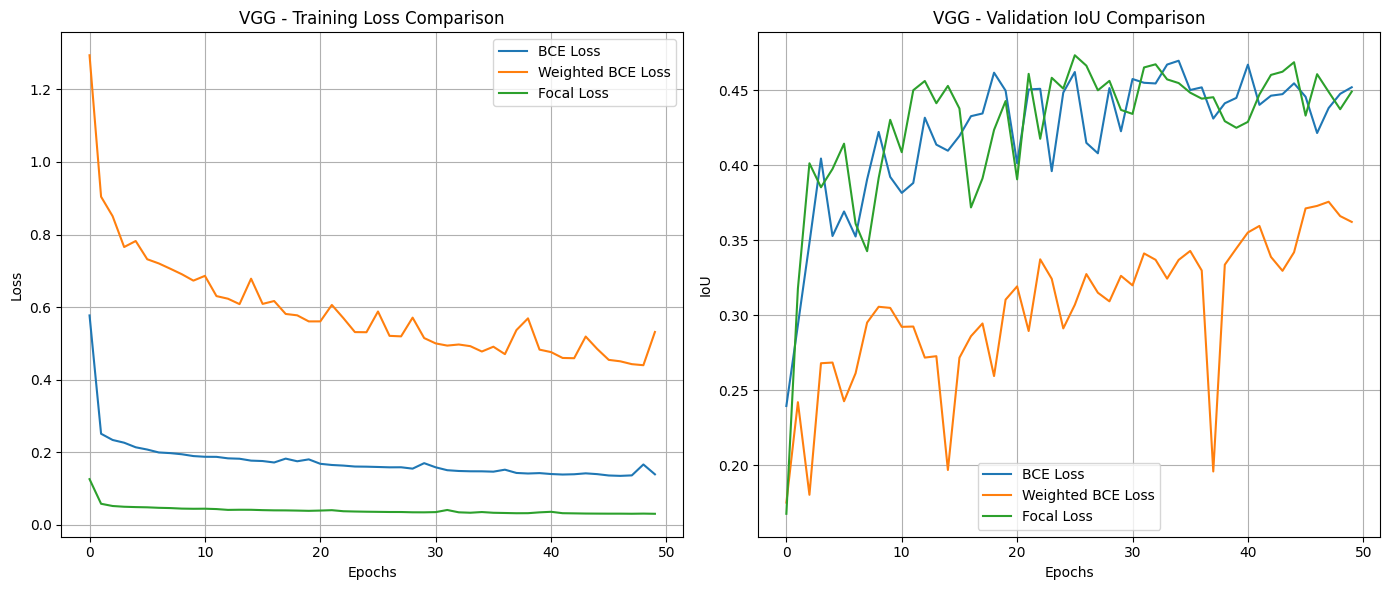

In [14]:
print("Plotting comparison graphs for VGG-Style Backbone...")
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for name, history in vgg_histories.items():
    plt.plot(history['train_loss'], label=name)
plt.title('VGG - Training Loss Comparison')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
for name, history in vgg_histories.items():
    plt.plot(history['val_iou'], label=name)
plt.title('VGG - Validation IoU Comparison')
plt.xlabel('Epochs'); plt.ylabel('IoU'); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()